Behavior of different numerical schemes for a moving shock wave.

We'll use a very busy road and a red light at x=4.  Cars will accumulate quickly in the front, where the max allowed density of cars will be between x=3 and x=4.  There is an incoming traffic of 50% the maximum allowed density ($\rho = 0.5 \rho_{max}$).

Mathematically it is $$\rho (x,0) = 0.5 \rho_{max}, 0 \leq x < 3$$
$$\rho (x,0) = \rho_{max}, 3 \leq x \leq 4$$

In [19]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [20]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes 'red light' initial condition with shock
    
    Parameters
    ----------
    nx : int
        Number of grid points in x
    rho_max : float
        Maximum allowed car density
    rho_in : float
        Density of incoming cars
    
    Returns
    -------
    rho : array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

In [21]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


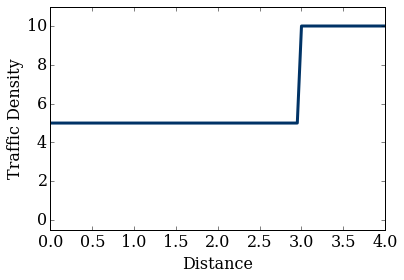

In [22]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic Density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

**How will cars accumulate at the red light?**

The problem will be solved using three different numerical schemes and their performance will be looked at.

Lax-Friedrichs, Lax-Wendroff, and MacCormack

The wave speed $u_{wave}$ is -1 for $\rho = \rho _{max}$ and $\rho \leq \rho _{max} / 2$ which makes all velocities negative.  We should see a solution moving left, maintaining shock geometry. 

In [23]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho
    
    Parameters
    ----------
    u_max : float
        Maximum allowed velocity
    rho : array of floats
        Array with density of cars at every point x
    rho_max : float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

In [24]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [25]:
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

**Lax-Friedrichs scheme**
Conservation law for vehicle traffic gives the following for traffic density: $$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$
F is traffic flux which in the linear traffic-speed model is given by: $$F = \rho u_{max} (1-\frac{\rho}{\rho _{max}})$$
In time, the natural choice for discretization is always a forward difference time because time invariably moves forward. $$\frac{\partial \rho}{\partial t} \approx \frac{1}{\Delta t} (\rho _i ^{n+1} - \rho _i ^n)$$
For space the simplest way to get second order accuray is to use central difference $$\frac{\partial F}{\partial x} \approx \frac{1}{2 \Delta x} (F_{i+1} - F_{i-1})$$
Combining these two for time and space discretization in the convection equation has catastrophic results.  The "forward-time, central scheme" (FTCS) is **unstable** (Definitely don't wanna try that)
The Lax-Friedrichs scheme (1954 by Lax) is a trick to stabilize the forward-time, central scheme.  The idea was to replace the solution value at $\rho _i ^n$ by the average of the values at the neighboring grid points.  This leads to: $$\frac{\rho _i ^{n+1} - \frac{1}{2} (\rho _{i+1} ^ n + \rho _{i-1} ^ n)}{\Delta t} = -\frac{F_{i+1} ^n - F_{i-1} ^n}{2 \Delta x}$$
This numerical discretization is **stable**. Unfortunately substituting $\rho _i ^n$ by the average of its neighbors introduces a first-order error.

To implement this sceheme in code, the value at the next step $\rho _i ^{n+1}$ needs to be isolated in order to write a time-step loop: $$\rho _i ^{n+1} = \frac{1}{2} (\rho _{i+1} ^n + \rho _{i-1} ^n) - \frac{\Delta t}{2 \Delta x} (F_{i+1} ^n - F_{i-1} ^2)$$

To display animations we're going to hold the results of each time-step in the variable rho which is a 2D array.  The resulting rho_n has nt rows and nx columns.

In [26]:
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    u_max : float
        Speed limit
    
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    # Initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    #Copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    """
    Now, for each timestep, we're going to calculate rho^n+1,
    then set the value of rho equal to rho^n+1 so we can calculate
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    """
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] #boundary contion at x=0
        rho_n[t,-1] = rho[-1] #boundary condition at x=4
        rho = rho_n[t].copy()
        
    return rho_n

In [27]:
#Trying Lax-Friedrichs with CFL = 1
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in) #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [28]:
rho_n.shape
#should be nt(30) by nx(81)

(30, 81)


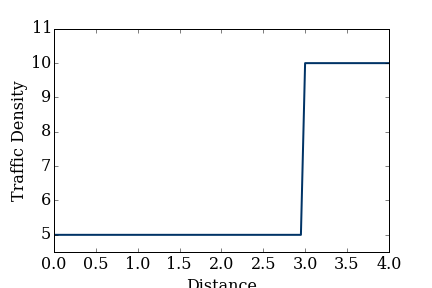
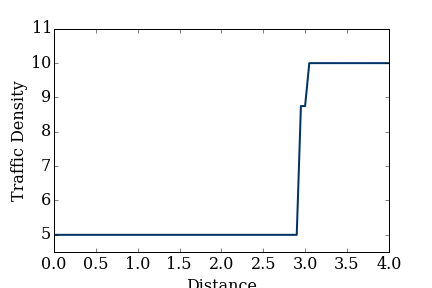
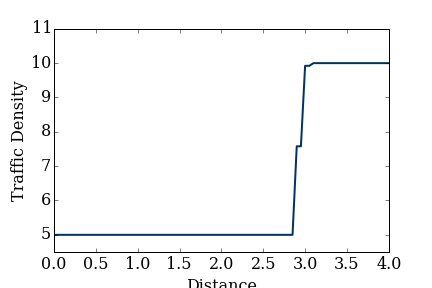
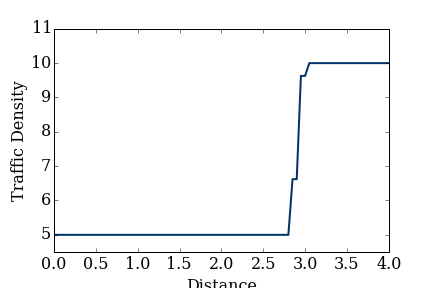
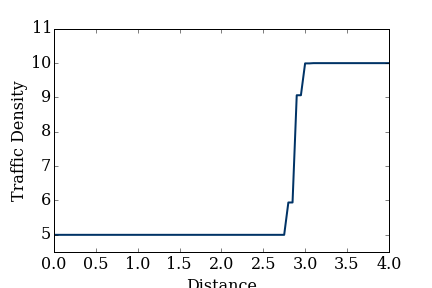
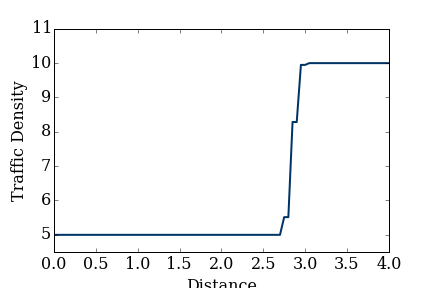
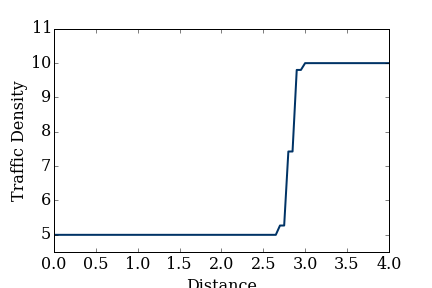
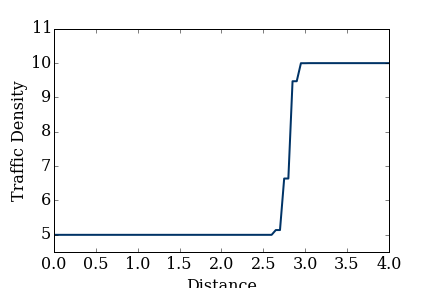
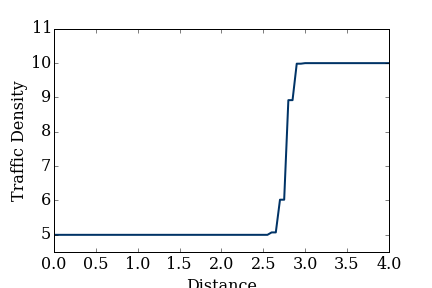
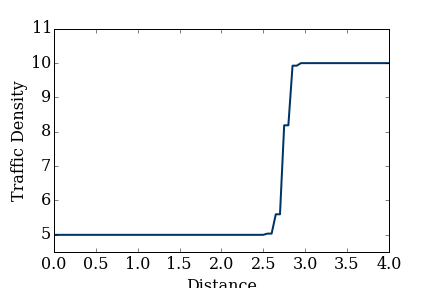
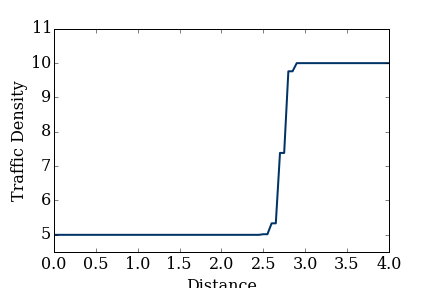
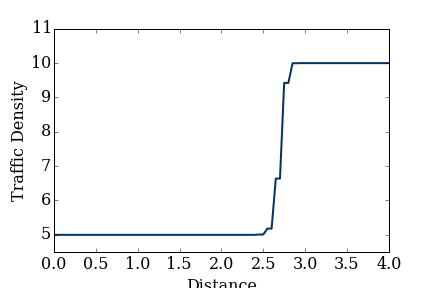
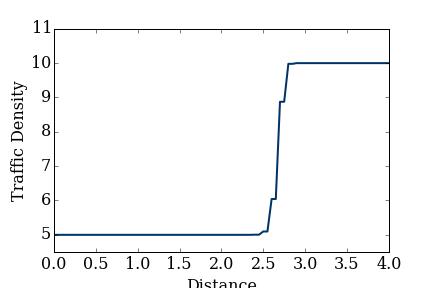
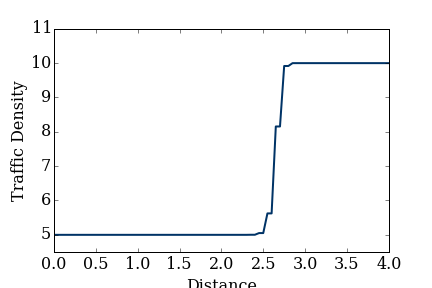
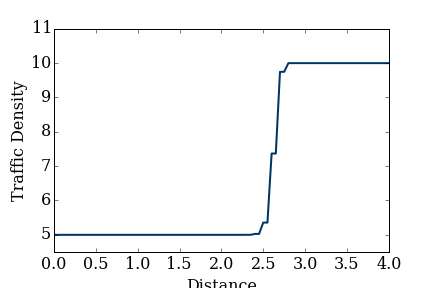
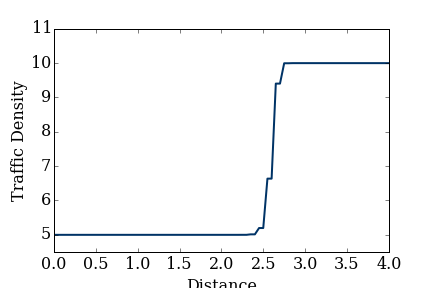
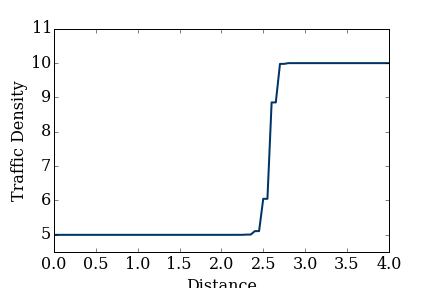
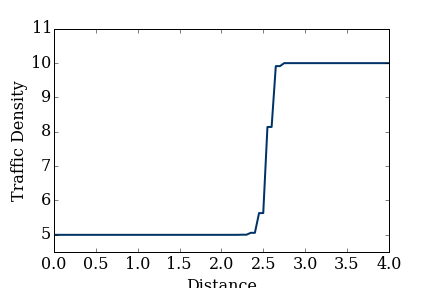
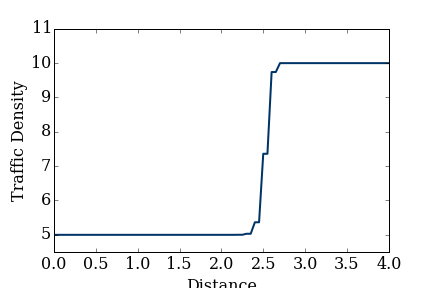
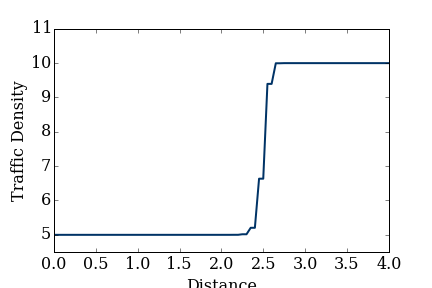
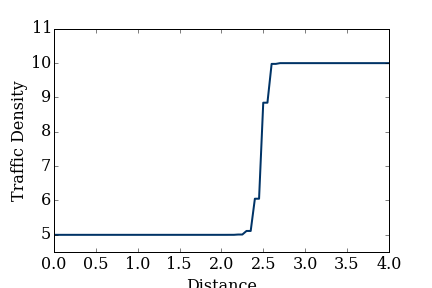
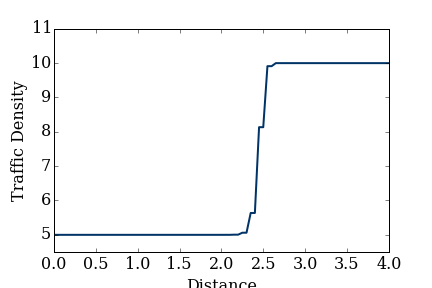
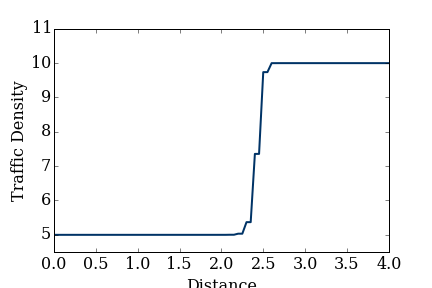
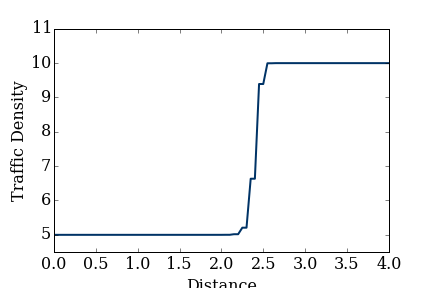
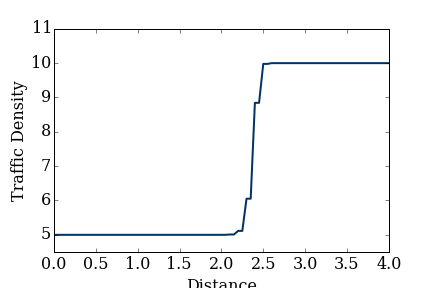
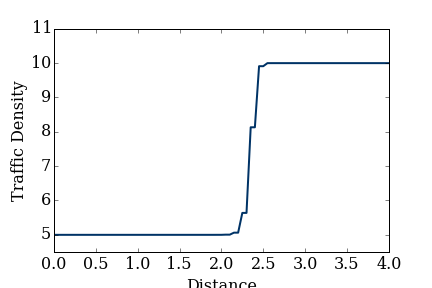
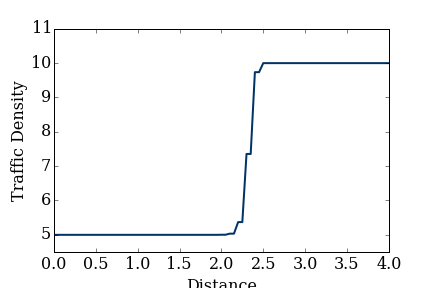
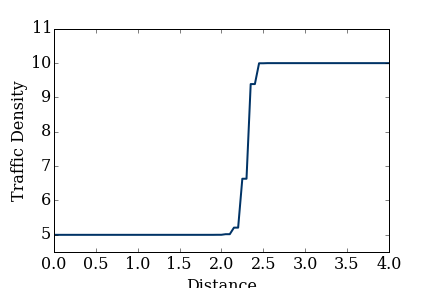
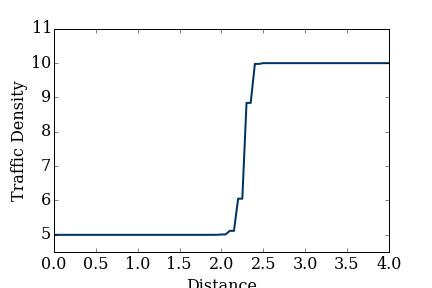
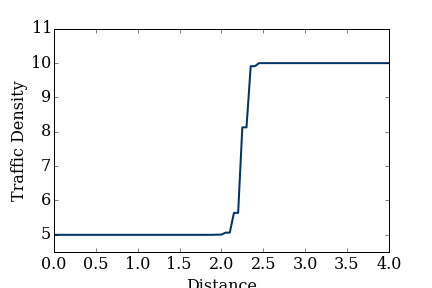

In [29]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(4.5,11), xlabel=('Distance'), ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [30]:
#Lax-Friedrichs with CFL = .5
sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in) #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



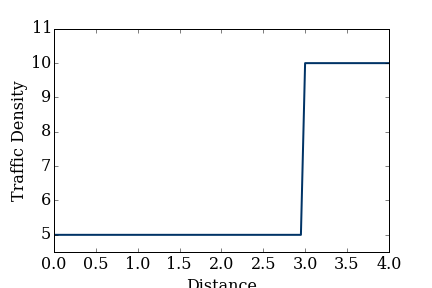
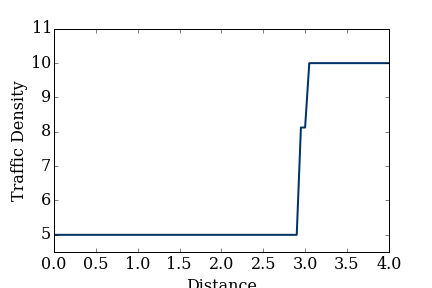
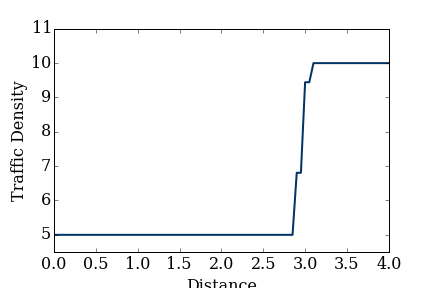
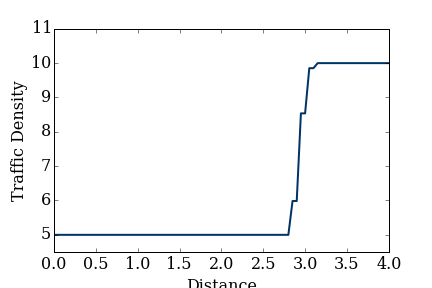
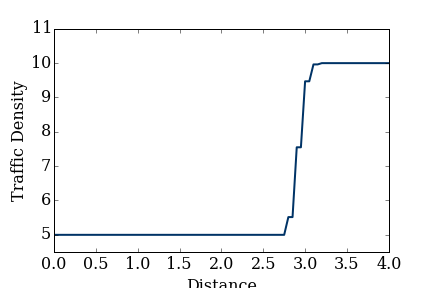
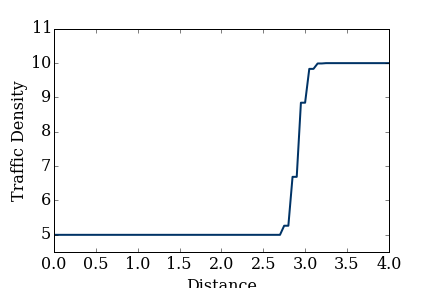
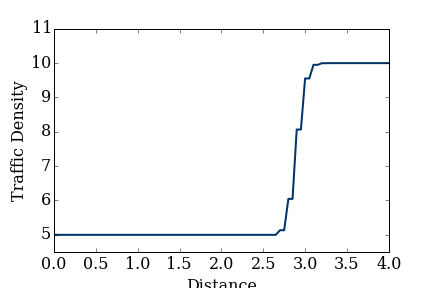
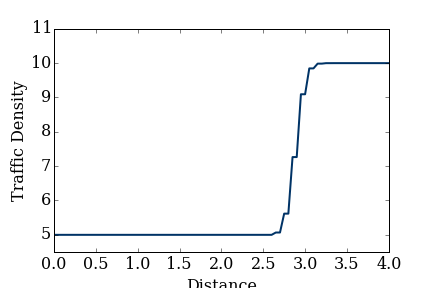
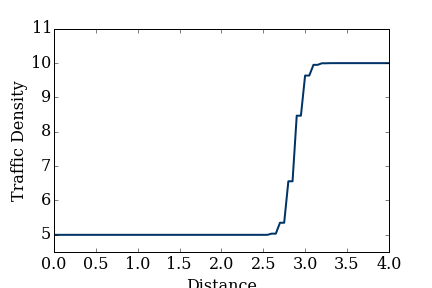
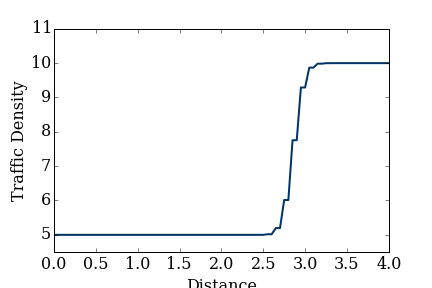
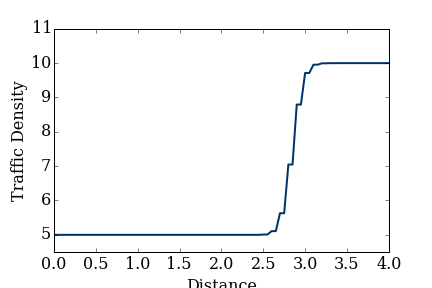
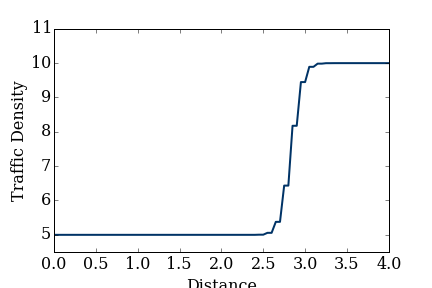
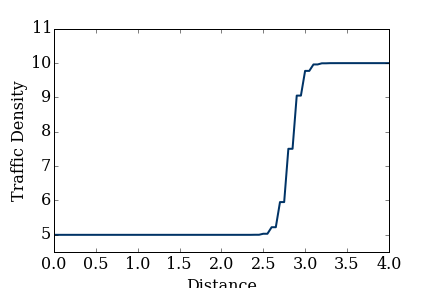
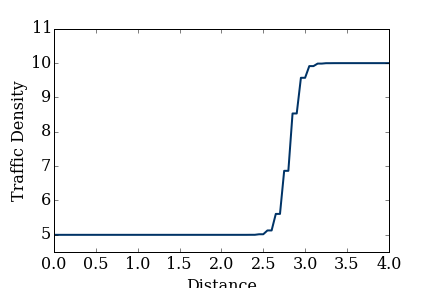
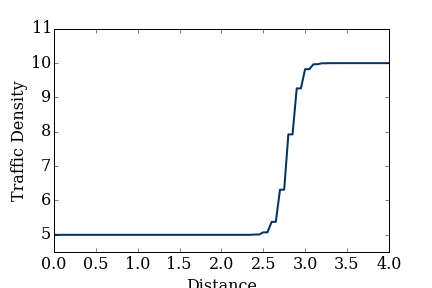
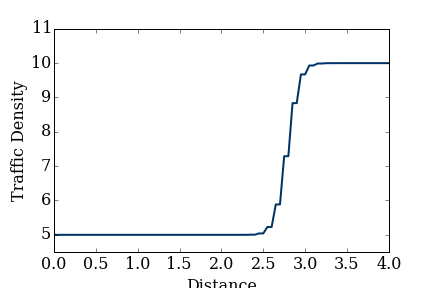
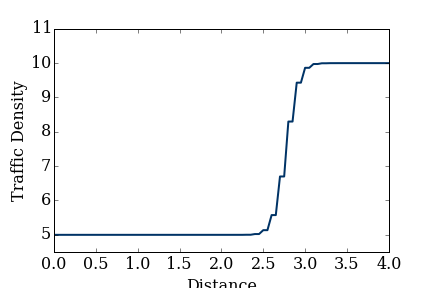
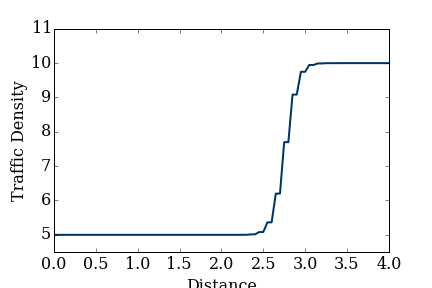
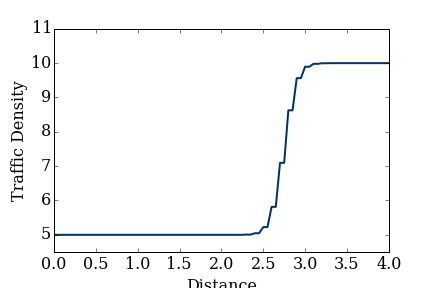
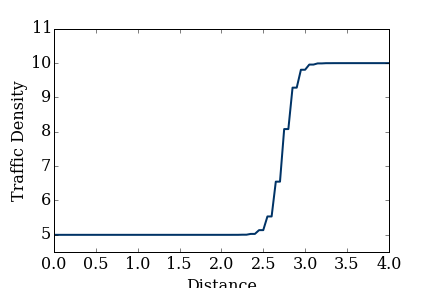
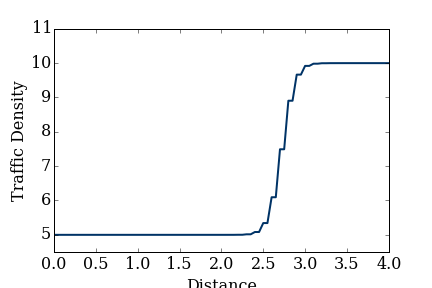
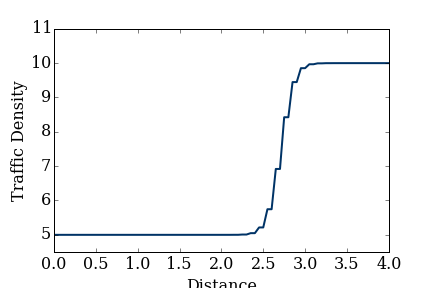
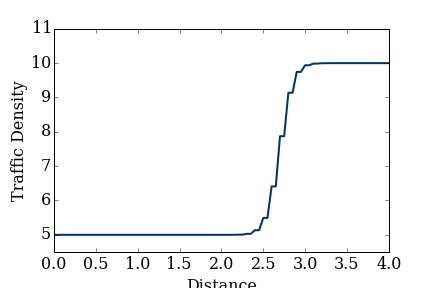
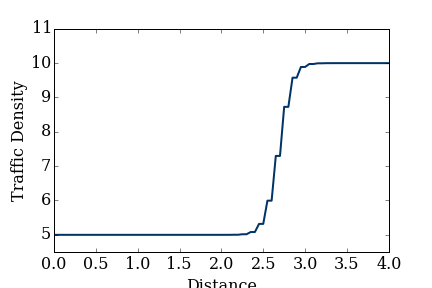
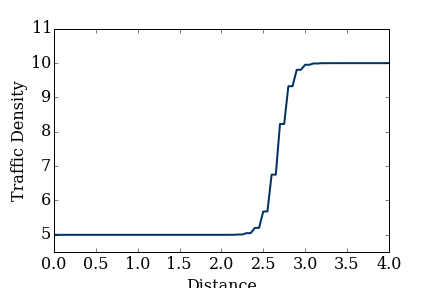
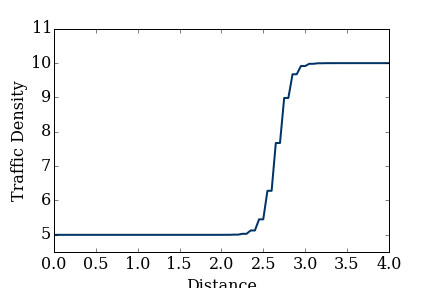
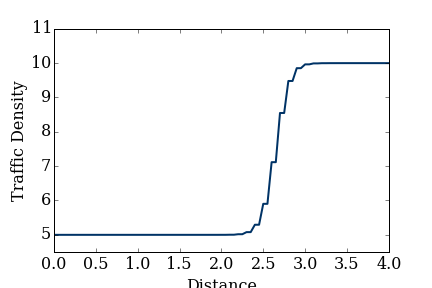
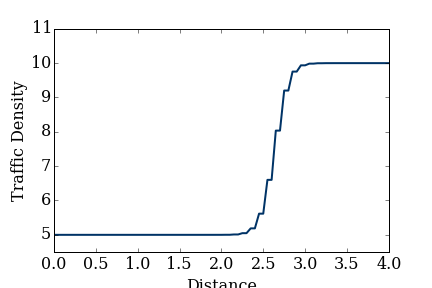
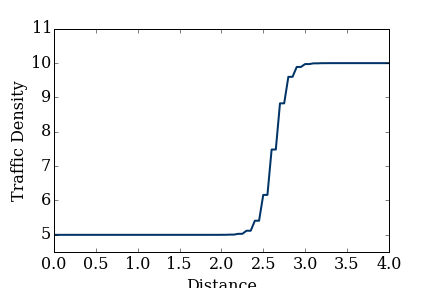
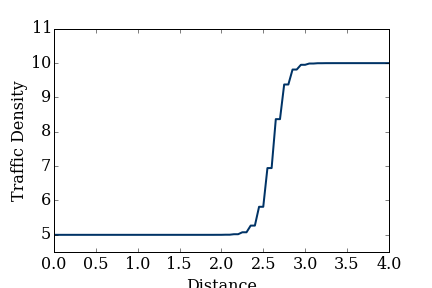

In [31]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

# Lax-Wendroff (1960)

First-order methods are not good enough for convection problems, especially when you have sharp gradients (shocks).

Lax-Wendroff was the first to acheive secord order accuracy in both space and time.

Starts with the Taylor series expansion in the time variable about $\rho^{n+1}$
$$\rho^{n+1} = \rho^n + \frac{\partial \rho^n}{\partial t} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial ^2 \rho^n}{\partial t^2} + ... $$
For the conservation law with $F = F(\rho)$ and using the chain rule we can get: $$\frac{\partial \rho}{\partial t} = -\frac{\partial F}{\partial x} = -\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = -J \frac{\partial \rho}{\partial x}$$
where: $$J = \frac{\partial F}{\partial \rho} = u_{max} (1 - 2 \frac{\rho}{\rho_{max}}$$
is the _Jacobian_ for the traffic model.  Next we can do a little trickery: $$\frac{\partial F}{\partial t} = \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial t} = J \frac{\partial \rho}{\partial t} = -J \frac{\partial F}{\partial x}$$
In that last step the differential equation of the traffic model replaced the time derivative by a spatial derivative which implies that: $$\frac{\partial ^2 \rho}{\partial t^2} = \frac{\partial}{\partial x} (J \frac{\partial F}{\partial x}$$
Using all of this in the Taylor expansion: $$\rho^{n+1} = \rho^n - \frac{\partial F^n}{\partial x} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial}{\partial x} (J \frac{\partial F^n}{\partial x}) + ...$$
We can now reorganize this and discretize the spatial derivatives with central differences to get the discrete equation: $$\frac{\rho_i ^{n+1} - \rho_i ^n}{\Delta t} = - \frac{F_{i+1} ^n - F_{i-1} ^n}{2 \Delta x} + \frac{\Delta t}{2} \left(\frac{(J \frac{\partial F}{\partial x})^n _{i+\frac{1}{2}} - (J \frac{\partial F}{\partial x})^n _{i-\frac{1}{2}}}{\Delta x}\right)$$
Next the rightmost term inside the parenthsis is approxiamted as: $$\frac{J_{i+\frac{1}{2}} ^n (\frac{F_{i+1} ^n - F_i ^n}{\Delta x}) - J_{i - \frac{1}{2}} ^ n (\frac{F_i ^n - F_{i-1} ^n}{\Delta x})}{\Delta x}$$
Then the Jacobian is evaluated at the midpoints by using averages of the points on either side: $$\frac{\frac{1}{2 \Delta x} (J_{i+1} ^n + J_i ^n) (F_{i+1} ^n - F_i ^n) - \frac{1}{2 \ Delta x} (J_i ^n + J_{i-1} ^n) (F_i ^n - F_{i-1} ^n)}{\Delta x}$$
The equation now reads as: $$\frac{\rho_i ^{n+1} - \rho_i ^n}{\Delta t} = - \frac{F_{i+1} ^n - F_{i-1} ^n}{2 \Delta x} + ... + \frac{\Delta t}{4 \Delta x^2} \left( (J_{i+1} ^n + J_i ^n) (F_{i+1} ^n - F_i ^n) - (J_i ^n + J_{i-1} ^n) (F_i ^n - F_{i-1} ^n) \right)$$

Solving for $\rho_i ^{n+1} :$
$$\rho_i ^{n+1} = \rho_i ^n - \frac{\Delta t}{2 \Delta x} (F_{i+1} ^ n - F_{i-1} ^n) + ... + \frac{(\Delta t)^2}{4 (\Delta x)^2} \left[ (J_{i+1} ^n + J_i ^n) (F_{i+1} ^n - F_i ^n) - (J_i ^n + J_{i-1} ^n) (F_i ^n - F_{i-1} ^n) \right]$$
with $$J_i ^n = \frac{\partial F}{\partial \rho} = u_{max} (1 - 2 \frac{\rho_i ^n}{\rho_{max}})$$

In [32]:
def Jacobian(u_max, rho_max, rho):
    return u_max*(1-2*rho/rho_max)

def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    """Computes the solution with Lax-Wendroff scheme
    
    Paramters
    ---------
    rho : array of flaots
        Density at current time-step
    nt : int
        Number of time steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    u_max : float
        Speed limit
    
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    # Initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    # Copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        J = Jacobian(u_max, rho_max, rho)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:] - F[:-2]) + dt**2/(4*dx**2)*((J[2:]+J[1:-1])*(F[2:]-F[1:-1]) - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[1]
        rho = rho_n[t].copy()
    
    return rho_n

In [33]:
#Lax-Wendroff with CFL = 1

rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



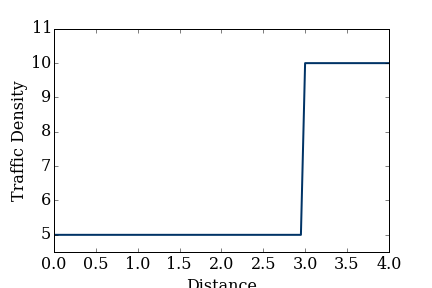
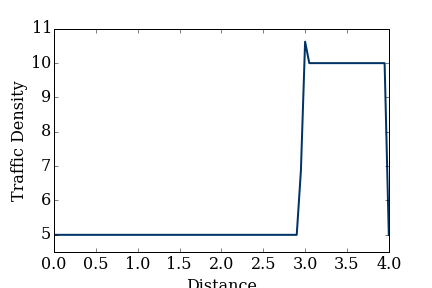
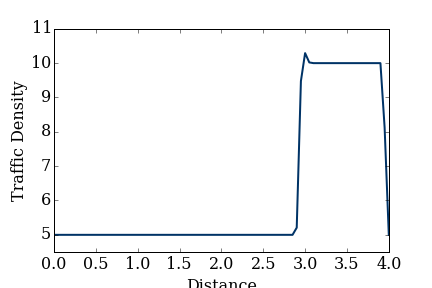
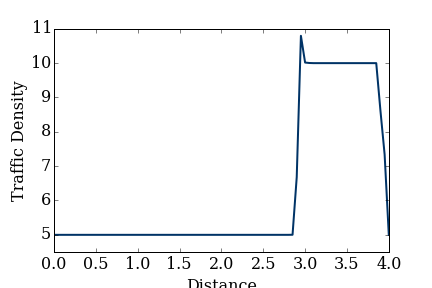
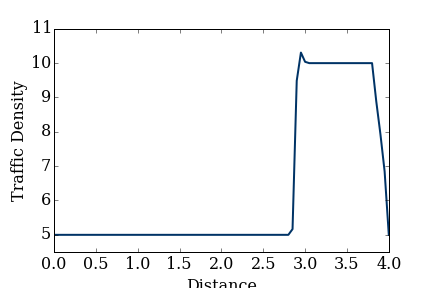
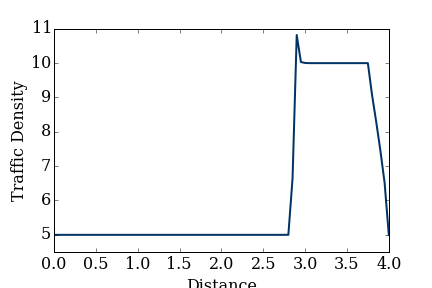
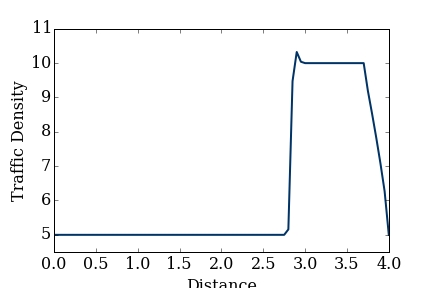
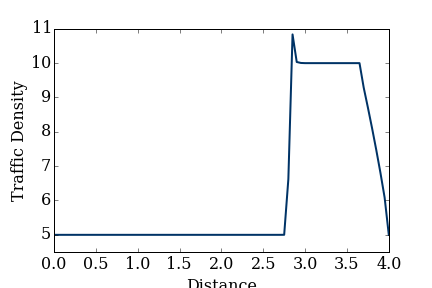
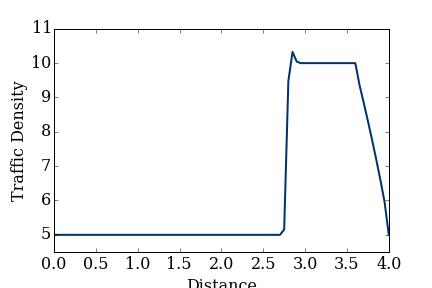
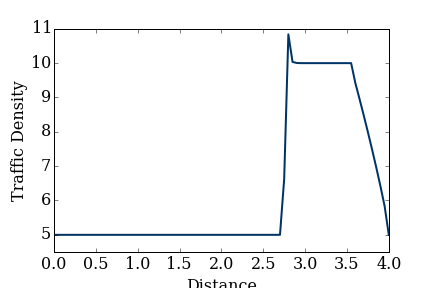
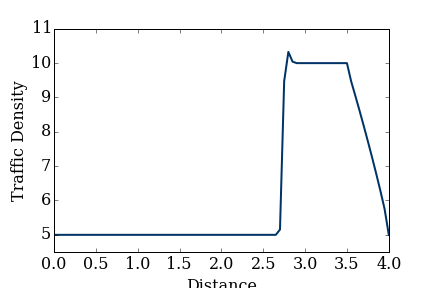
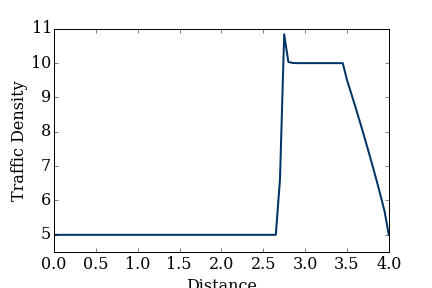
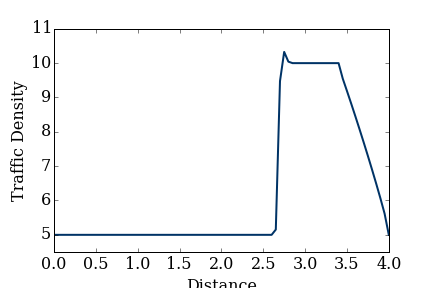
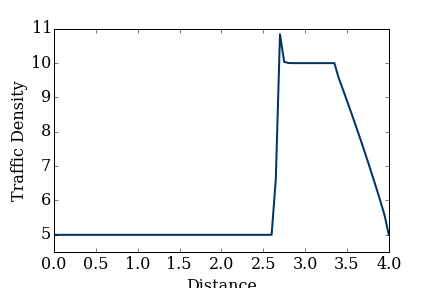
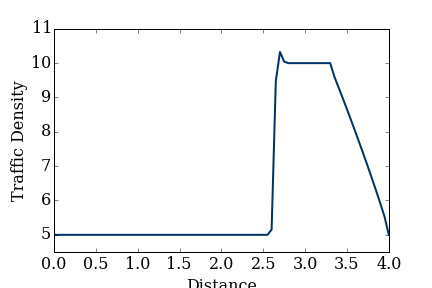
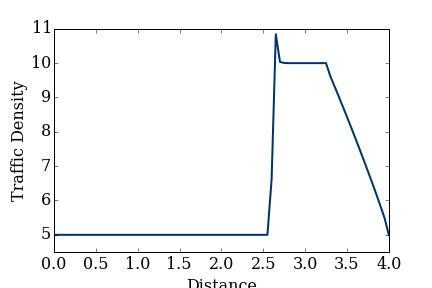
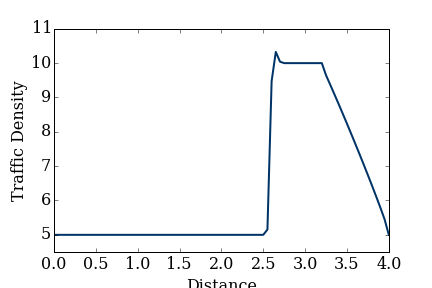
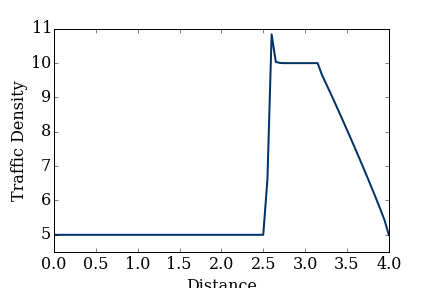
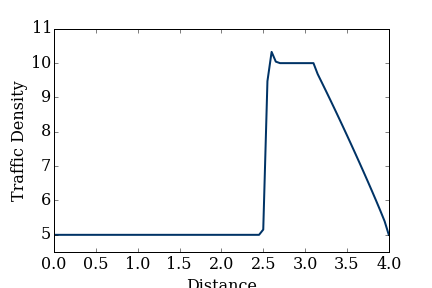
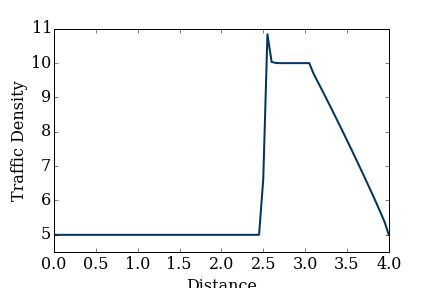
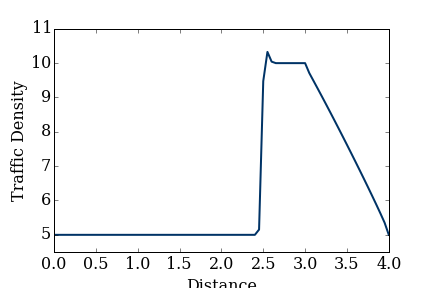
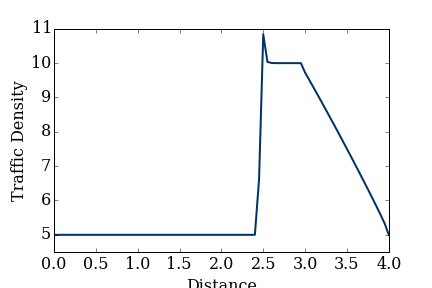
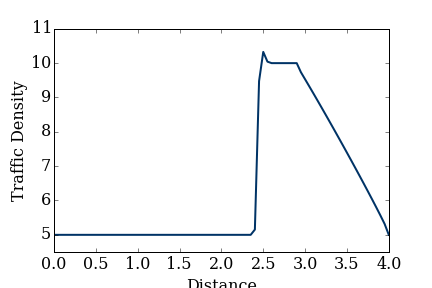
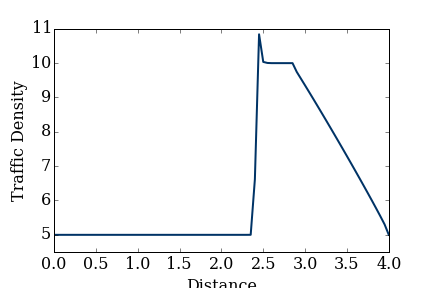
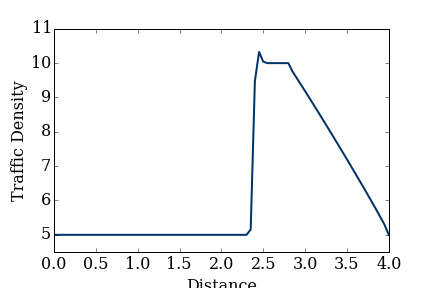
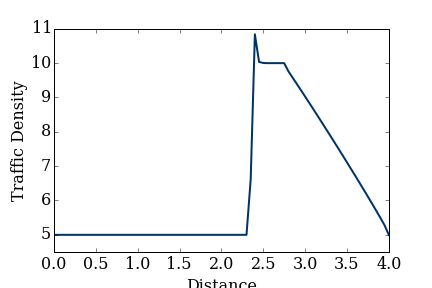
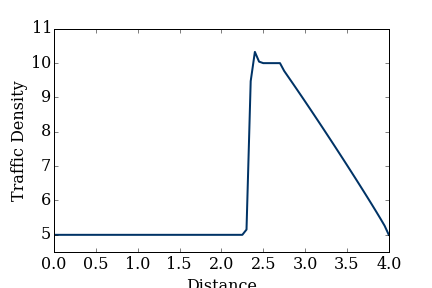
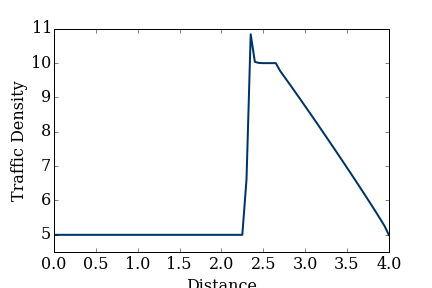
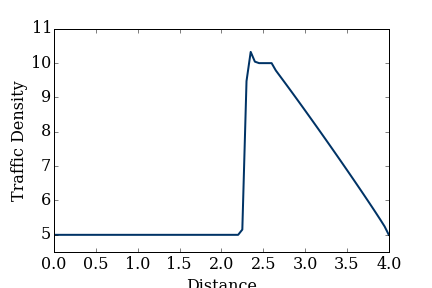
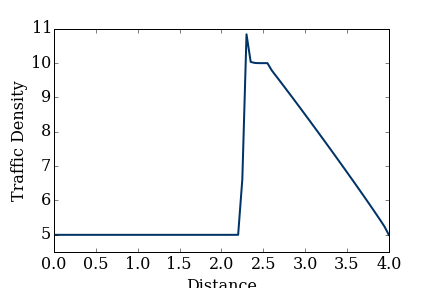

In [34]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(4.5,11.), xlabel=('Distance'), ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



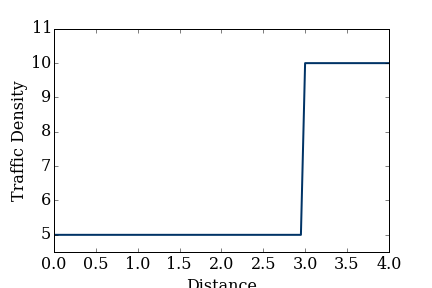
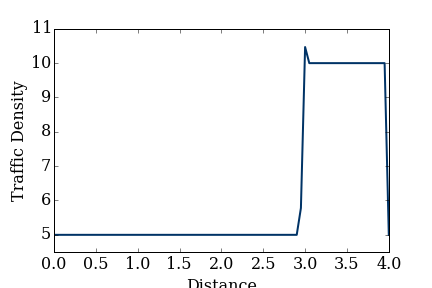
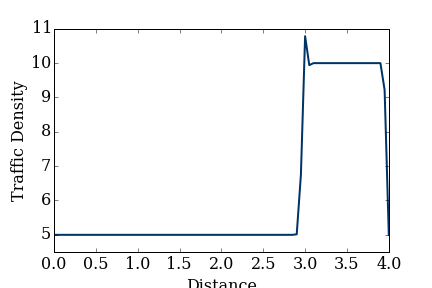
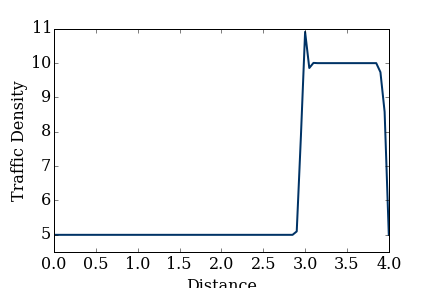
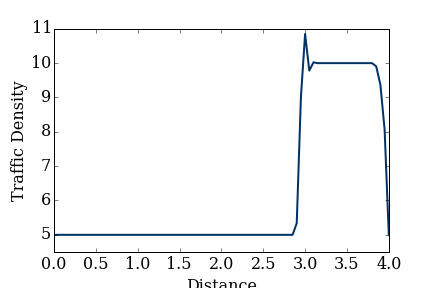
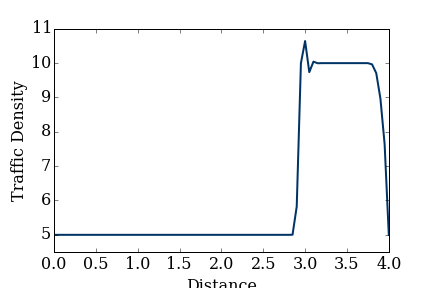
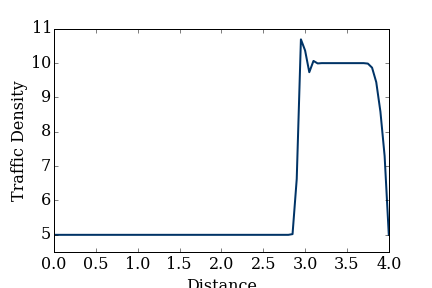
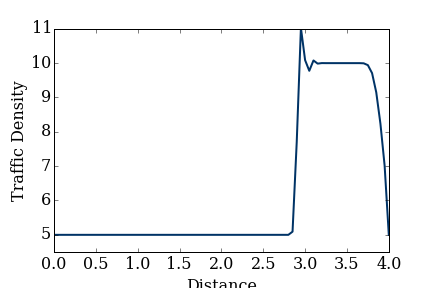
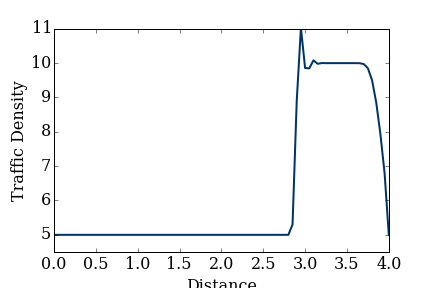
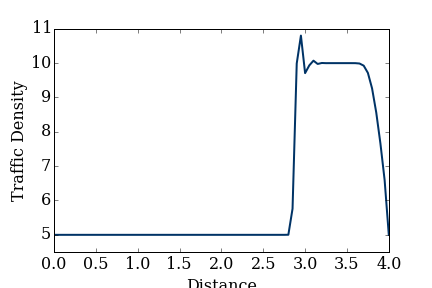
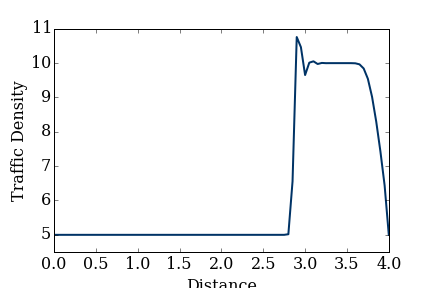
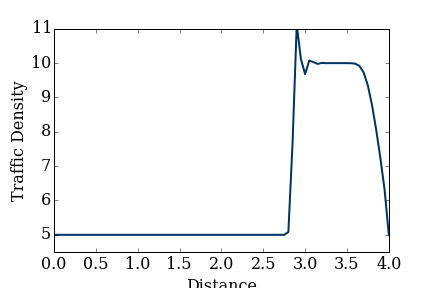
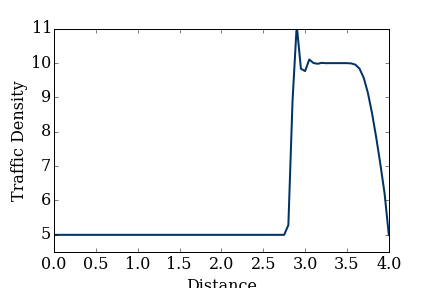
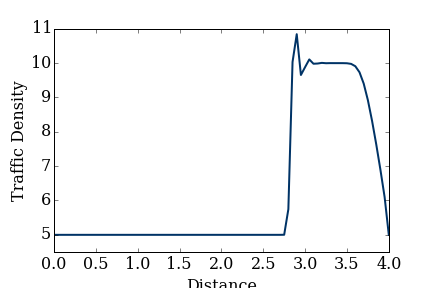
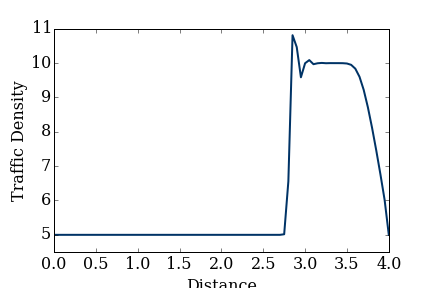
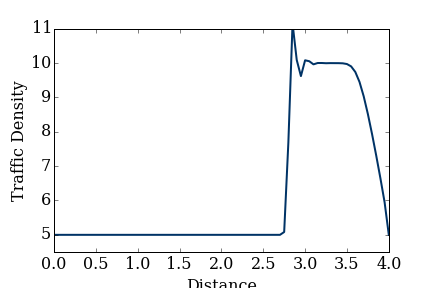
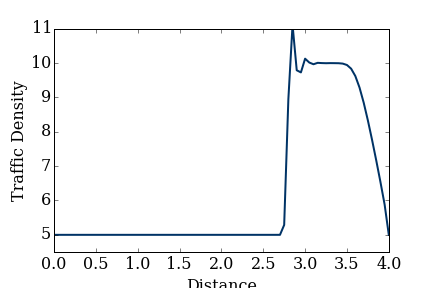
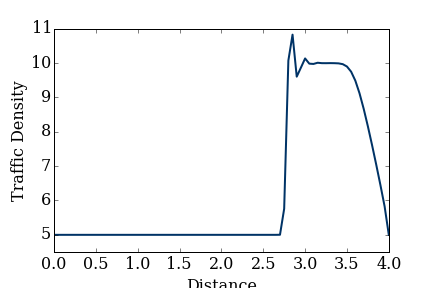
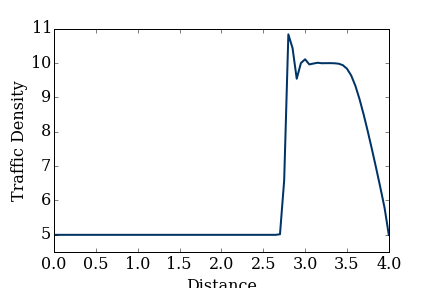
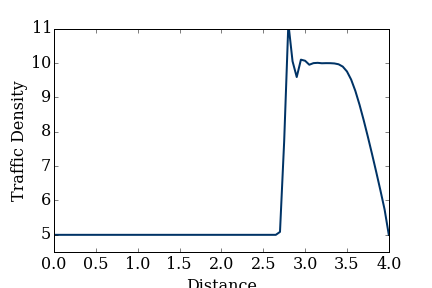
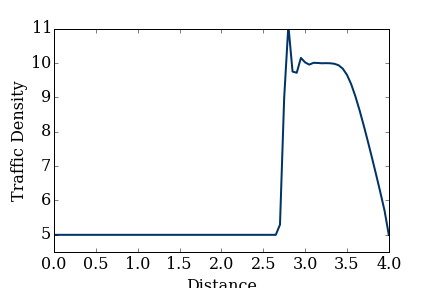
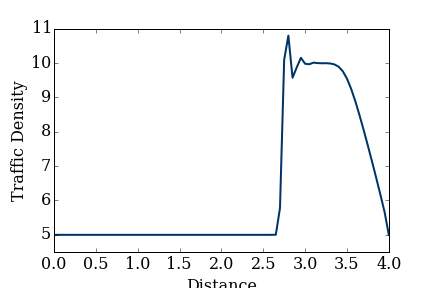
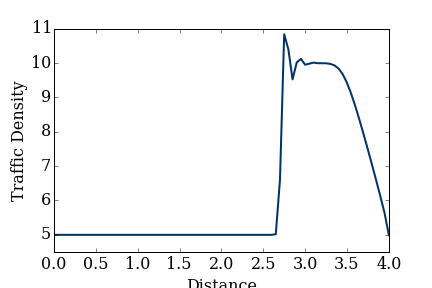
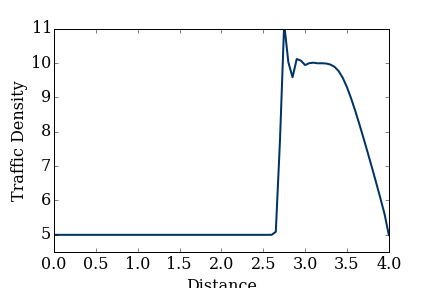
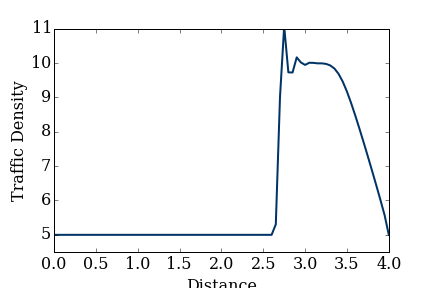
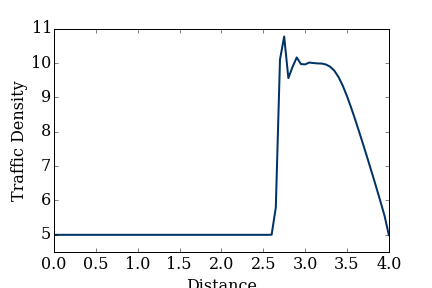
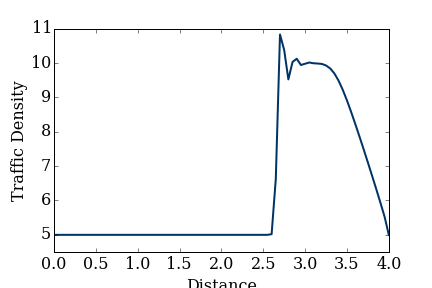
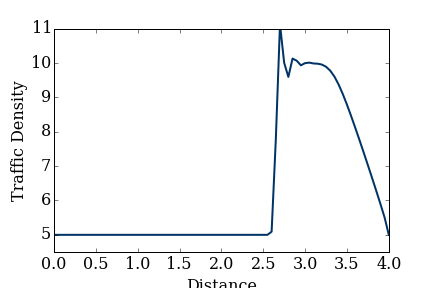
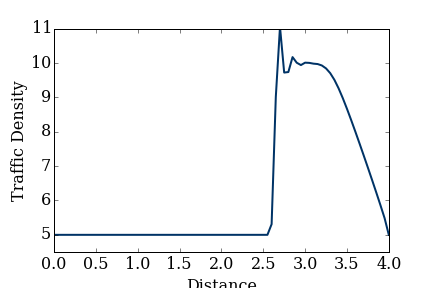
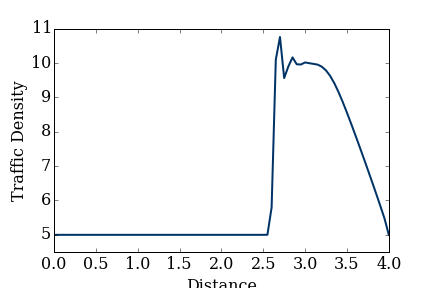

In [40]:
#Lax-Wendroff CFL = .5

rho = rho_red_light(nx, rho_max, rho_in)
sigma = 0.5
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366',lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

# MacCormack Scheme
Two-step method.  The first step is called a predictor and the second is called a corrector.  It achieves second-order accuracy in both space and time.

$$\rho_i ^* = \rho_i ^n - \frac{\Delta t}{\Delta x} (F_{i+1} ^n - F_i ^n), (Predictor)$$

$$\rho_i ^{n+1} = \frac{1}{2} (\rho_i ^n + \rho_i ^* - \frac{\Delta t}{\Delta x} (F_i ^* - F_{i-1} ^*)), (Corrector)$$

In [41]:
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time-steps
    dt : float
        Time step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    u_max : float
        Speed limit
        
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_max, rho_star)
        rho_n[t,1:] = .5 * (rho[1:]+rho_star[1:] - dt/dx*(Fstar[1:]-Fstar[:-1]))
        rho = rho_n[t].copy()
        
    return rho_n

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



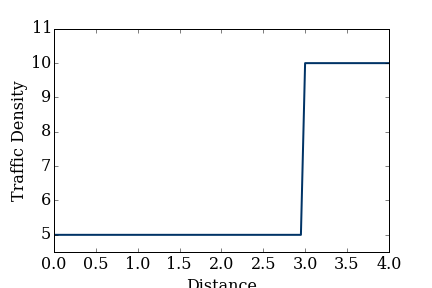
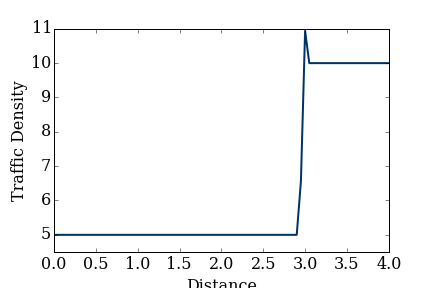
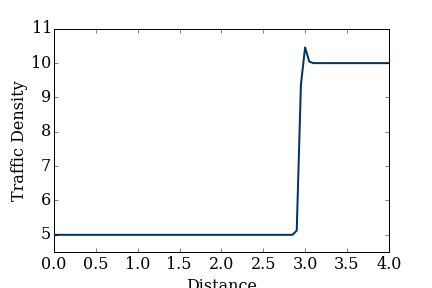
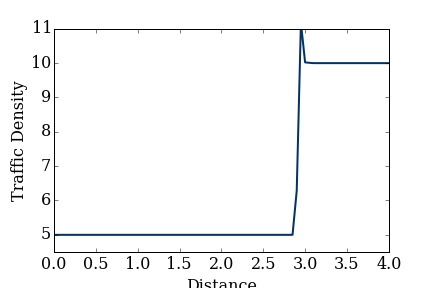
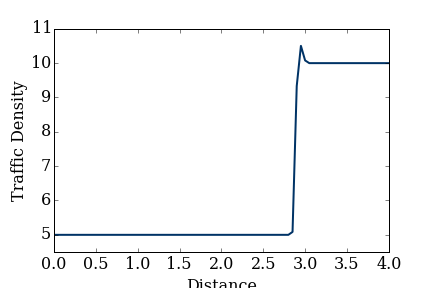
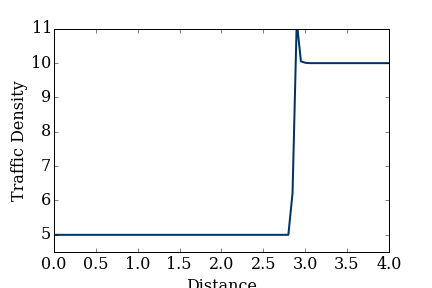
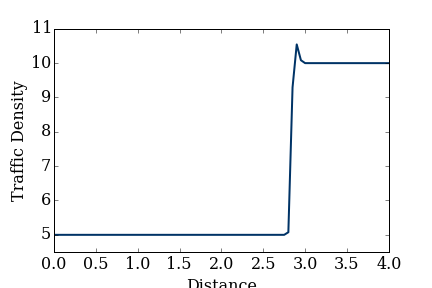
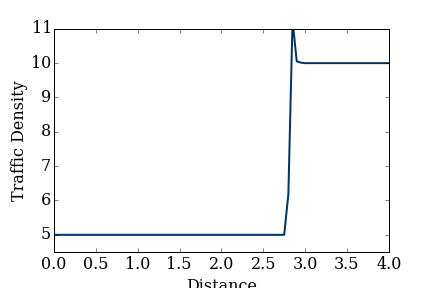
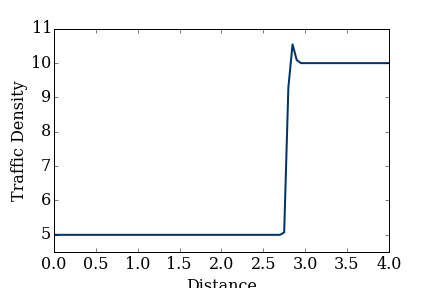
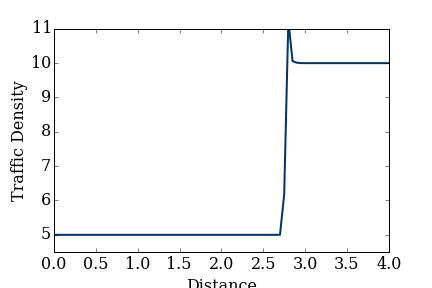
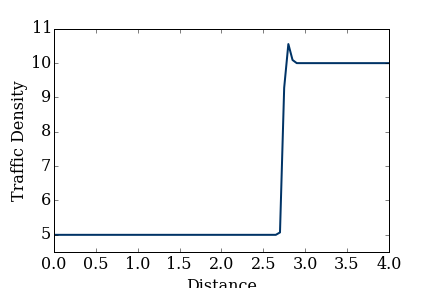
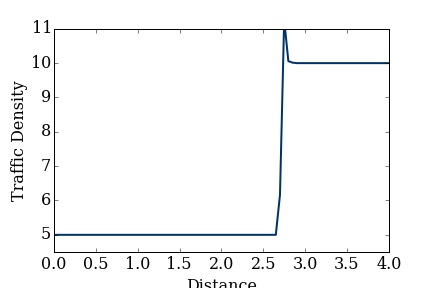
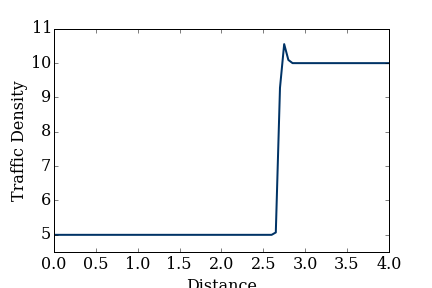
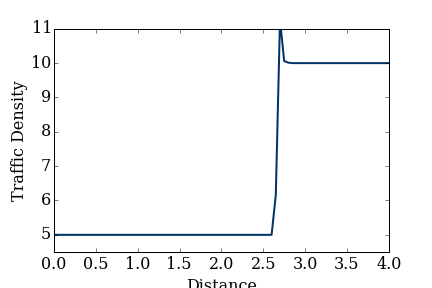
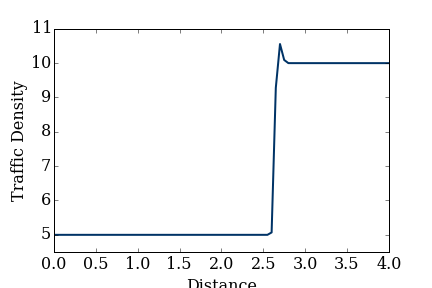
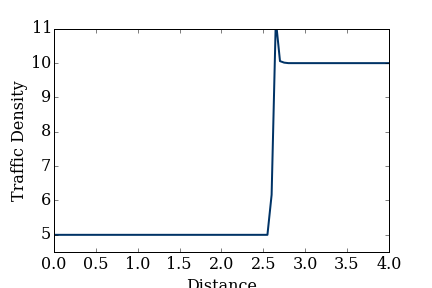
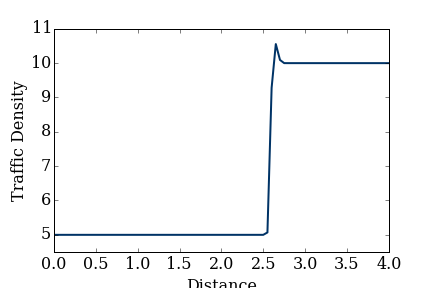
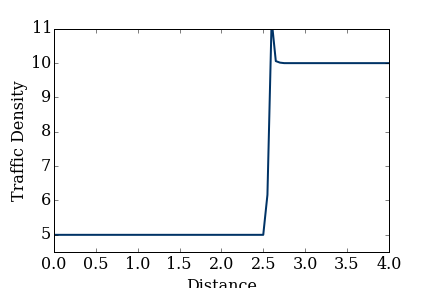
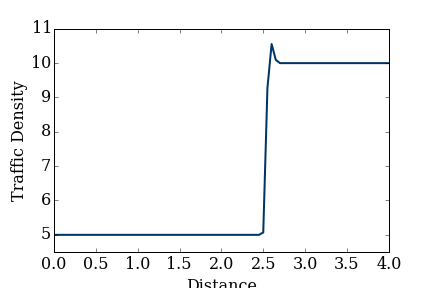
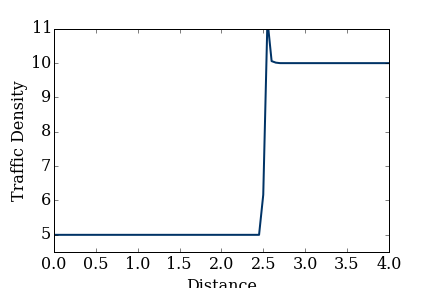
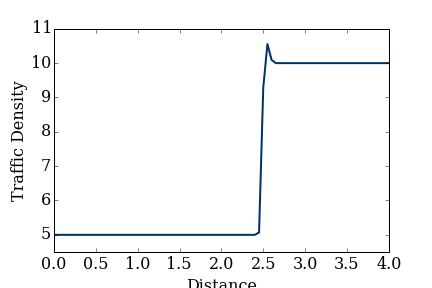
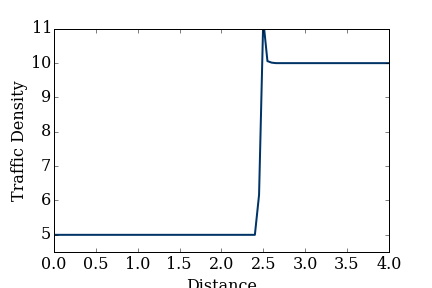
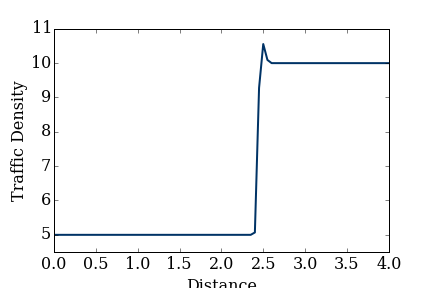
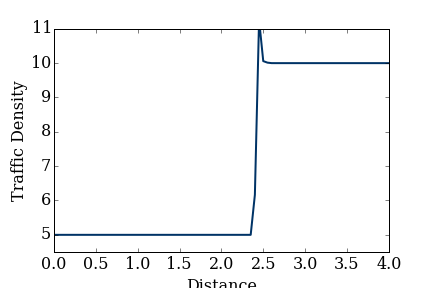
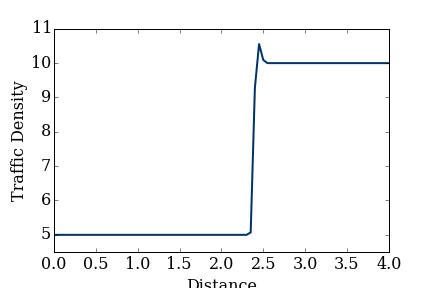
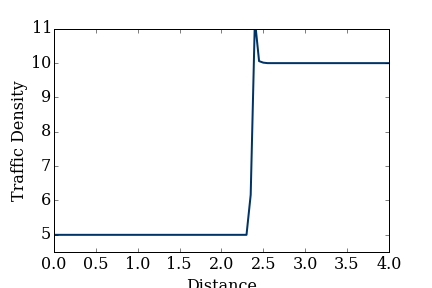
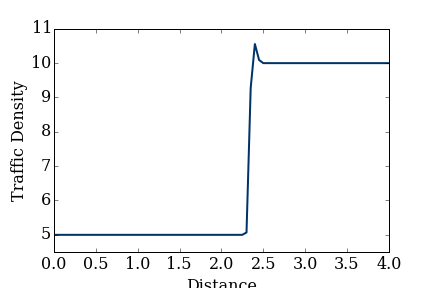
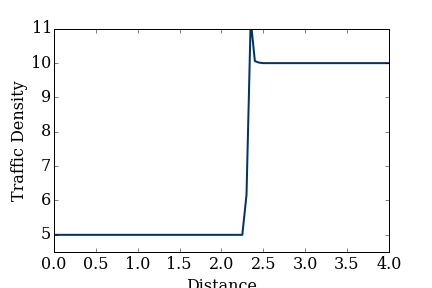
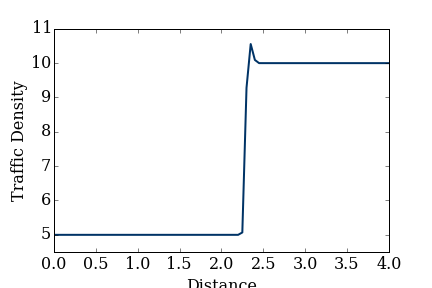
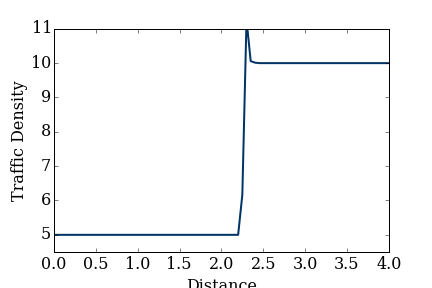

In [43]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1.0
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366',lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



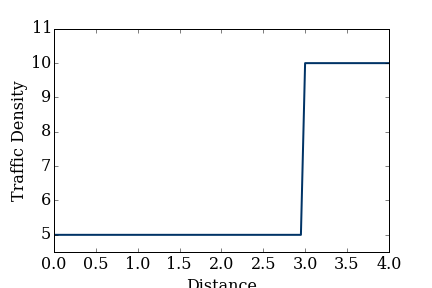
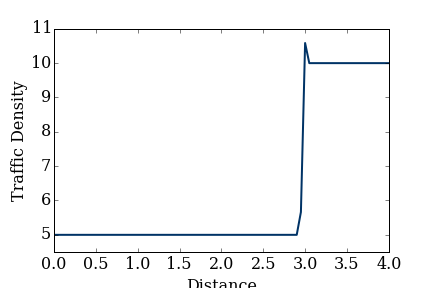
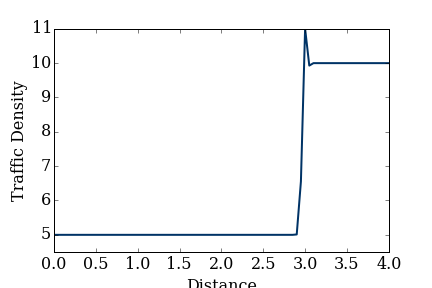
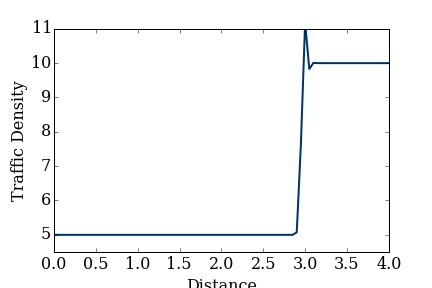
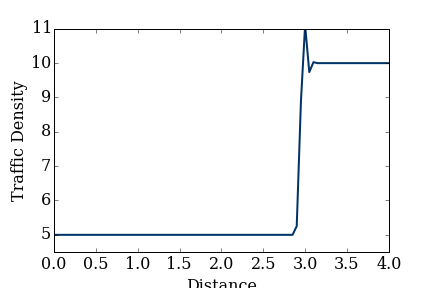
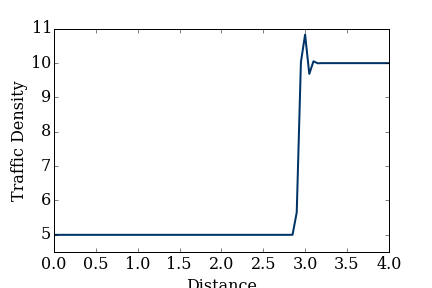
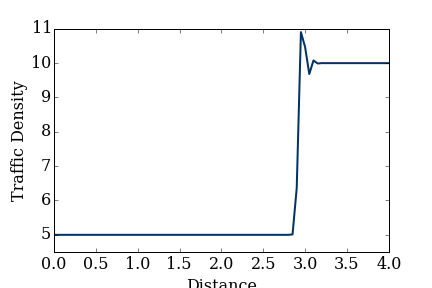
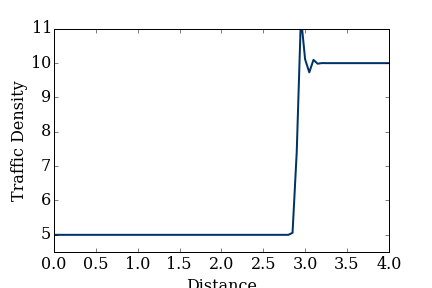
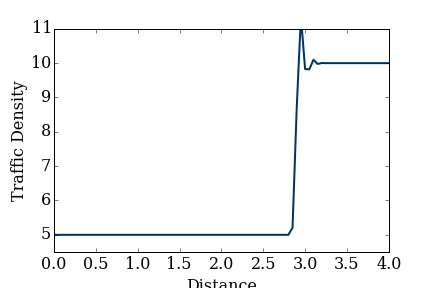
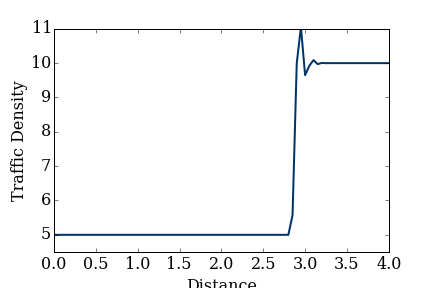
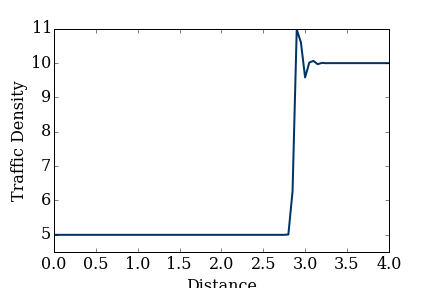
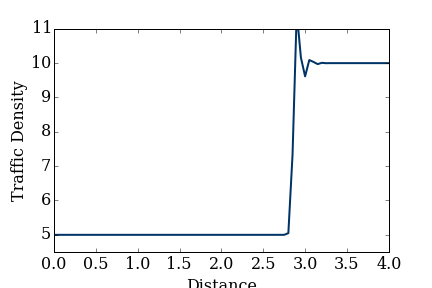
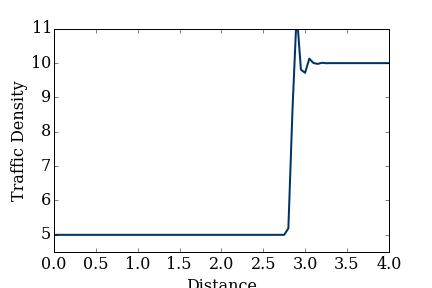
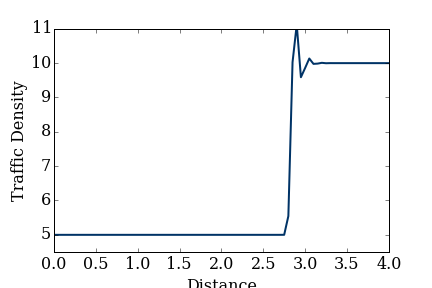
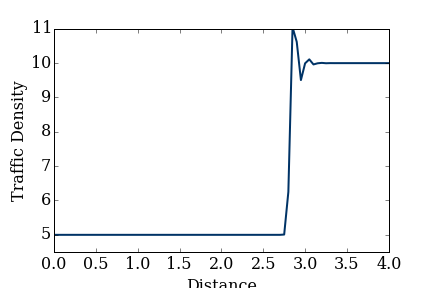
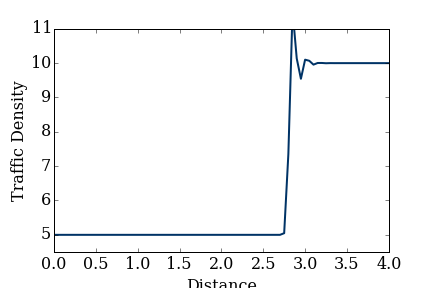
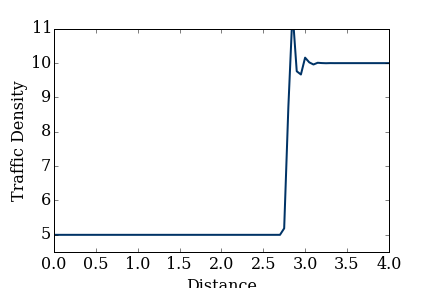
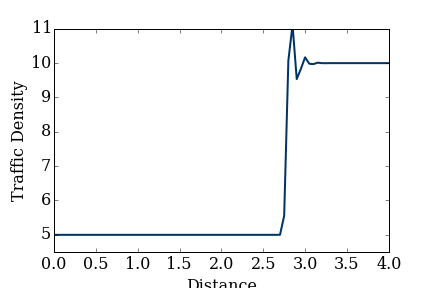
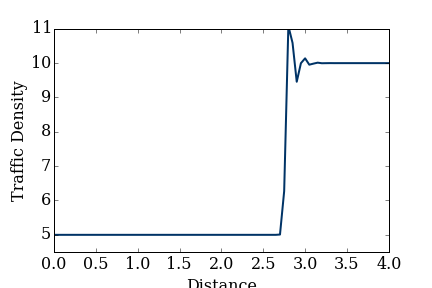
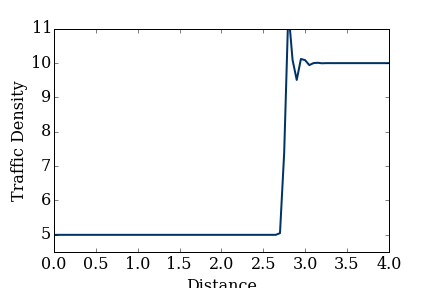
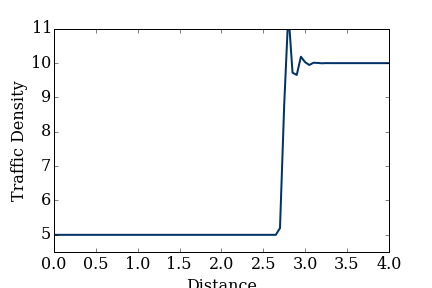
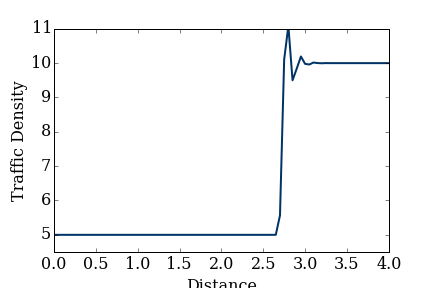
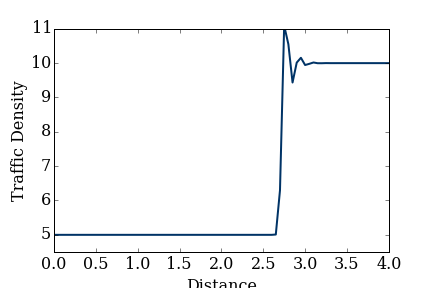
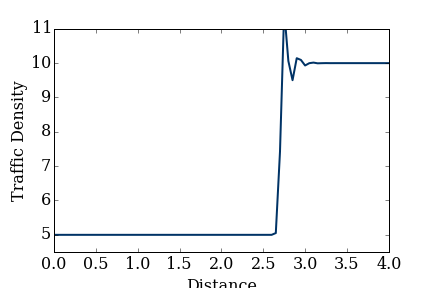
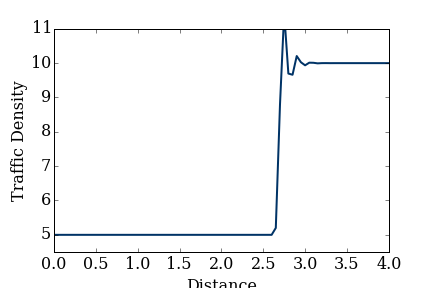
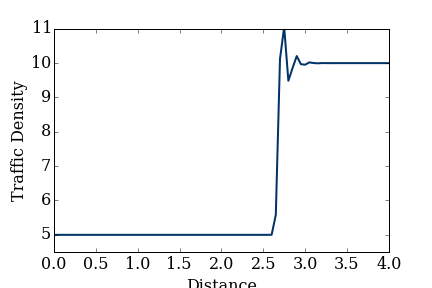
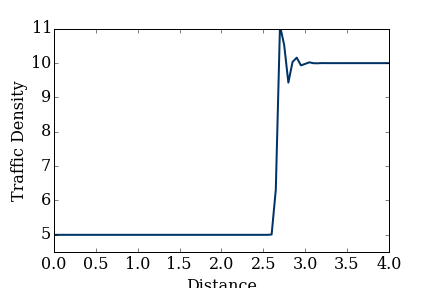
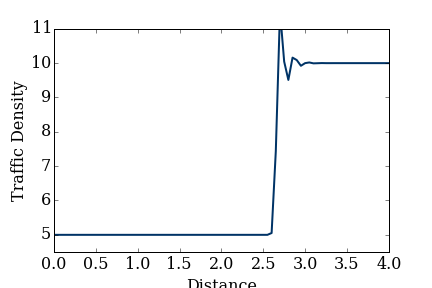
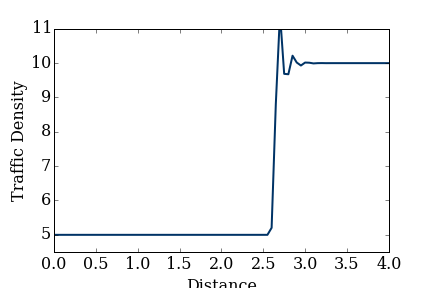
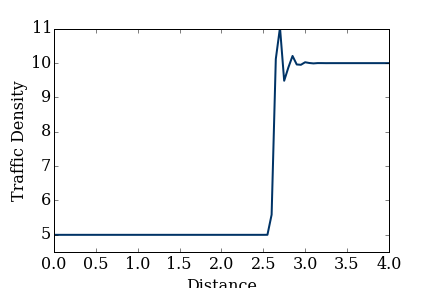

In [44]:
#MacCormack with CFL = .5

rho = rho_red_light(nx, rho_max, rho_in)
sigma = .5
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366',lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')